In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from google.colab import drive
from matplotlib.colors import LogNorm
from os.path import join
import torch.quantization as tq
from torch.quantization import QuantStub, DeQuantStub
import copy
drive.mount("/content/drive")
import os
import wandb
from copy import deepcopy
from typing import List, Tuple
import time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/MyDrive/classes/COMSE6998/

 Cloud_MKL_Setup.pdf
 fbg2107_jcl2259_cjr2210-HPML_final_project_proposal.pdf
 fbg2107.tar
 final_example_residual_only.png
 final_example_residual.png
 finalPlot_training_set.png
 HPML-01-Fall25.pdf
 HPML-02-Fall25.pdf
'HPML-03-Opt Algos and Pytorch-Columbia-Fall25.pdf'
 HPML-04-Pytorch-performance-Columbia-Fall2025.pdf
 HPML-05-CUDA-basics-Fall25.pdf
 HPML-06-CUDA-Advanced-Fall25.pdf
 HPML09-Quantization-Fall2025.pdf
 HPML11-KnowledgDistitllation-Columbia-Fall25.pdf
 HPML-5-CUDA-basics-Fall25.pdf
 HPML-7-DDL-Fall2025-columbia.pdf
 HPML8-pruning-Columbia-Fall2025.pdf
 HPML_Assignment4_Fall2025.pdf
 HPML_Assignments_Fall2025-1.pdf
 HPML_Assignments_Fall2025.pdf
'HPML Final Project'
 pset1
 pset2
 pset3
 pset4
 quantized_density_to_phase_grad.ipynb
 test.npz
 train.npz
 val.npz
 workergpu026_898503.1761097554771672195.pt.trace.json


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/classes/COMSE6998/"
model_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/models"

In [4]:
print(device)

cuda


In [5]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [6]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()

Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



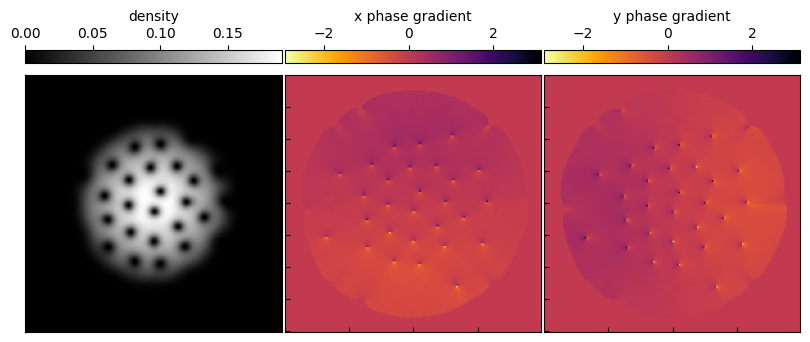

In [7]:
# Visualize an example
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Calculate shared vmin and vmax for phase gradients
vmin_phase = np.min(train_data["phase_gradients"][idx, :])
vmax_phase = np.max(train_data["phase_gradients"][idx, :])

im1 = ax[0].imshow(train_data["densities"][idx], cmap="gray", origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04, location="top")
cbar1.set_label("density")
im2 = ax[1].imshow(
    train_data["phase_gradients"][idx, 0],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04, location="top")
cbar2.set_label("x phase gradient")
im3 = ax[2].imshow(
    train_data["phase_gradients"][idx, 1],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar3 = fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04, location="top")
cbar3.set_label("y phase gradient")

# remove tick label, but preserve marks
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

plt.savefig(
    os.path.join(data_loc, "finalPlot_training_set.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

# Custom Datasets/Dataloaders

In [8]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask


train_dataset = BecDataset(
    train_data["densities"], train_data["phase_gradients"], train_data["masks"]
)
val_dataset = BecDataset(
    val_data["densities"], val_data["phase_gradients"], val_data["masks"]
)
test_dataset = BecDataset(
    test_data["densities"], test_data["phase_gradients"], test_data["masks"]
)

# UNET Definition

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, out_channels = 1, wrap_angles = False, verbose=False):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x

# Training


In [10]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )


def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(val_loader, model, device=device)
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(
            f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}"
        )




In [11]:
def mse_with_mask(outputs, targets, masks, keep_first_dim=False):
    """
    # Custom Loss function
    # Ignores losses for masked out regions (mask = 1), as these are
    # Low density regions and we don't care whether we get them right or not
    """
    if keep_first_dim:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks), dim=(-1, -2, -3))
    else:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks))
#______
batch_size = 8
epochs = 10

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_dataset, num_workers=2)
test_loader = DataLoader(test_dataset, num_workers=2)

unet = UNet(
    channels=[1, 8, 16, 32, 64, 128, 256, 512],
    out_channels=2,
    verbose=False
)

optimizer = optim.Adam(unet.parameters(), lr=1e-3)

train_model(
    train_loader,
    unet,
    mse_with_mask,
    optimizer,
    epochs=epochs,
    device=device
)


Epoch 1 Train Loss: 0.011820443724799488, Val Loss: 0.007579376921057701
Epoch 2 Train Loss: 0.006019677944658767, Val Loss: 0.005335030145943165
Epoch 3 Train Loss: 0.004755280758549888, Val Loss: 0.0044783940538764
Epoch 4 Train Loss: 0.0038736603123002817, Val Loss: 0.0038109449669718742
Epoch 5 Train Loss: 0.0034437140150527868, Val Loss: 0.003622806165367365
Epoch 6 Train Loss: 0.003084150701022101, Val Loss: 0.003065526718273759
Epoch 7 Train Loss: 0.002724205606639208, Val Loss: 0.0024552757386118174
Epoch 8 Train Loss: 0.002412765263764572, Val Loss: 0.002119126496836543
Epoch 9 Train Loss: 0.002118649836149185, Val Loss: 0.0021476983092725277
Epoch 10 Train Loss: 0.002021930666477789, Val Loss: 0.0021708845160901546


In [12]:
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downs): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): Batch

### quantization post training (good for inference)

In [13]:
# First, define a function to collect activations (modify for your data)
def collect_activations_for_unet(model, data_loader, device, num_batches=10):
    """Collect activations from the trained UNet model"""
    model.eval()

    # Initialize lists to store activations
    model.input_activations = []

    # Initialize activation collectors for all Conv layers
    def init_activation_collector(module):
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            module.activations = []

    model.apply(init_activation_collector)

    # Define hook functions
    def input_hook(module, input):
        model.input_activations.append(input[0].detach().cpu().numpy())

    def activation_hook(module, input, output):
        if hasattr(module, 'activations'):
            module.activations.append(output.detach().cpu().numpy())

    # Register hooks
    hooks = []

    # Hook for input
    input_hook_handle = model.register_forward_pre_hook(input_hook)
    hooks.append(input_hook_handle)

    # Hooks for all Conv layers
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            hook_handle = module.register_forward_hook(activation_hook)
            hooks.append(hook_handle)

    # Collect activations
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch_idx >= num_batches:
                break

            # Assuming your dataset returns (data, target, mask)
            # Adjust based on your actual dataset structure
            if len(batch) == 3:
                data, _, _ = batch
            elif len(batch) == 2:
                data, _ = batch
            else:
                data = batch[0]

            data = data.to(device)
            _ = model(data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Convert lists to numpy arrays
    if model.input_activations:
        model.input_activations = np.concatenate(model.input_activations)

    # Convert layer activations
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)) and hasattr(module, 'activations'):
            if module.activations:
                module.activations = np.concatenate(module.activations)
            else:
                # If no activations were collected (shouldn't happen), create empty array
                module.activations = np.array([])

    return model



In [14]:
def quantize_unet_weights_simple(model: nn.Module):
    """Simple brute-force quantization - modifies in-place"""
    model = copy.deepcopy(model)

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            # Calculate scale
            max_weight = torch.max(torch.abs(module.weight.data))
            scale = 127.0 / max_weight.item() if max_weight > 0 else 1.0

            # Apply quantization
            module.weight.scale = scale
            with torch.no_grad():
                module.weight.data = (module.weight.data * scale).round()
                module.weight.data = torch.clamp(module.weight.data, -128, 127)

            print(f"Quantized {name}: scale={scale:.2f}")

    return model

# Test the simple version
print("\n" + "="*60)
print("TESTING SIMPLE quantize_unet_weights")
print("="*60)

unet_simple_quantized = quantize_unet_weights_simple(unet)

# Quick check
print("\nQuick check:")
for name, module in unet_simple_quantized.named_modules():
    if isinstance(module, nn.Conv2d) and "inc.double_conv.0" in name:
        print(f"{name}: has_scale={hasattr(module.weight, 'scale')}")
        if hasattr(module.weight, 'scale'):
            print(f"  Scale: {module.weight.scale:.2f}")
            print(f"  Weights are integers: {torch.allclose(module.weight.data, module.weight.data.round(), atol=1e-4)}")
        break


TESTING SIMPLE quantize_unet_weights
Quantized inc.double_conv.0: scale=305.16
Quantized inc.double_conv.3: scale=655.26
Quantized downs.0.maxpool_conv.1.double_conv.0: scale=867.37
Quantized downs.0.maxpool_conv.1.double_conv.3: scale=962.94
Quantized downs.1.maxpool_conv.1.double_conv.0: scale=899.77
Quantized downs.1.maxpool_conv.1.double_conv.3: scale=1161.62
Quantized downs.2.maxpool_conv.1.double_conv.0: scale=1077.29
Quantized downs.2.maxpool_conv.1.double_conv.3: scale=1654.86
Quantized downs.3.maxpool_conv.1.double_conv.0: scale=1649.93
Quantized downs.3.maxpool_conv.1.double_conv.3: scale=2074.91
Quantized downs.4.maxpool_conv.1.double_conv.0: scale=2058.68
Quantized downs.4.maxpool_conv.1.double_conv.3: scale=2369.49
Quantized downs.5.maxpool_conv.1.double_conv.0: scale=2303.64
Quantized downs.5.maxpool_conv.1.double_conv.3: scale=2525.15
Quantized downs.6.maxpool_conv.1.double_conv.0: scale=2978.21
Quantized downs.6.maxpool_conv.1.double_conv.3: scale=2770.82
Quantized ups

In [15]:
class UNetQuantized(nn.Module):
    def __init__(self, unet_with_weights_quantized: nn.Module, add_skip=True, bilinear=True):
        super(UNetQuantized, self).__init__()

        # Copy the quantized model
        unet_init = copy_unet_model(unet_with_weights_quantized)

        # Copy all submodules
        self.inc = unet_init.inc
        self.downs = unet_init.downs
        self.ups = unet_init.ups
        self.outc = unet_init.outc

        # Store parameters
        self.add_skip = add_skip
        self.bilinear = bilinear

        # Calculate scaling factors
        if hasattr(unet_with_weights_quantized, 'input_activations'):
            self.input_activations = unet_with_weights_quantized.input_activations
            self.input_scale = self.quantize_initial_input(self.input_activations)
        else:
            # Default if no activations collected
            self.input_scale = 1.0

        # We need to track scales for all conv layers in order
        self.layer_scales = []
        self._calculate_layer_scales_fixed()

    def _calculate_layer_scales_fixed(self):
        """Calculate output scales for all layers - FIXED VERSION"""
        conv_layers = self._get_all_conv_layers()
        preceding_layer_scales = []

        for layer in conv_layers:
            # Get weight scale safely
            weight_scale = getattr(layer.weight, 'scale', None)

            # Get activations if available
            activations = getattr(layer, 'activations', None)

            if weight_scale is not None and activations is not None and len(activations) > 0:
                layer.output_scale = self.quantize_activations_fixed(
                    activations,
                    weight_scale,
                    self.input_scale,
                    preceding_layer_scales,
                )
                preceding_layer_scales.append((weight_scale, layer.output_scale))
                self.layer_scales.append((layer, weight_scale, layer.output_scale))
            else:
                # Use default scale if missing data
                default_scale = 1.0
                layer.output_scale = default_scale
                if weight_scale is not None:
                    preceding_layer_scales.append((weight_scale, default_scale))
                    self.layer_scales.append((layer, weight_scale, default_scale))
                else:
                    # If no weight scale, use 1.0 for both
                    preceding_layer_scales.append((1.0, default_scale))
                    self.layer_scales.append((layer, 1.0, default_scale))

    def _get_all_conv_layers(self):
        """Get all convolution layers in forward pass order"""
        layers = []

        def get_convs_from_module(module):
            convs = []
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                convs.append(module)
            elif isinstance(module, (nn.Sequential, DoubleConv, Down, Up, OutConv)):
                for child in module.children():
                    convs.extend(get_convs_from_module(child))
            return convs

        # Get from inc
        layers.extend(get_convs_from_module(self.inc))

        # Get from downs
        for down in self.downs:
            layers.extend(get_convs_from_module(down))

        # Get from ups
        for up in self.ups:
            layers.extend(get_convs_from_module(up))

        # Get from outc
        layers.extend(get_convs_from_module(self.outc))

        return layers

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        """Calculate scaling factor for initial input"""
        if pixels is None or len(pixels) == 0:
            return 1.0
        max_abs = np.max(np.abs(pixels))
        if max_abs == 0:
            return 1.0
        scale = 127.0 / max_abs
        return scale

    @staticmethod
    def quantize_activations_fixed(
        activations: np.ndarray,
        n_w: float,
        n_initial_input: float,
        ns: List[Tuple[float, float]],
    ) -> float:
        """Calculate scaling factor for layer output - FIXED to handle None"""
        # Handle None cases
        if activations is None or len(activations) == 0:
            return 1.0

        if n_w is None:
            n_w = 1.0

        activations_np = np.array(activations)
        cumulative_scale = n_initial_input

        for prev_weight_scale, prev_output_scale in ns:
            if prev_weight_scale is None:
                prev_weight_scale = 1.0
            cumulative_scale *= prev_weight_scale * prev_output_scale

        max_abs = np.max(np.abs(activations_np))

        if max_abs == 0:
            return 1.0

        scale_product = cumulative_scale * n_w

        if scale_product == 0:
            return 1.0

        n_output = 127.0 / (max_abs * scale_product)
        return n_output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Scale and quantize input
        x = (x * self.input_scale).round()
        x = torch.clamp(x, min=-128, max=127)

        # Store intermediate activations for skip connections
        x_stages = []

        # Helper function to apply layer with quantization
        def apply_layer(module, x):
            # Apply the module
            x = module(x)

            # Find output scale if available
            output_scale = getattr(module, 'output_scale', None)
            if output_scale is not None:
                x = (x * output_scale).round()
                x = torch.clamp(x, min=-128, max=127)

            return x

        # Initial convolution
        x = apply_layer(self.inc, x)
        x_stages.append(x)

        # Down path
        for down in self.downs:
            x = apply_layer(down, x)
            x_stages.append(x)

        # Up path
        x = x_stages.pop()
        for up in self.ups:
            # Get skip connection
            skip = x_stages.pop()

            # Apply up module (special handling for skip connections)
            x1 = up.up(x)

            # Pad if necessary
            diffY = skip.size()[2] - x1.size()[2]
            diffX = skip.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                           diffY // 2, diffY - diffY // 2])

            # Concatenate if using skip connections
            if self.add_skip and hasattr(up, 'add_skip') and up.add_skip:
                x = torch.cat([skip, x1], dim=1)
            else:
                x = x1

            # Apply the DoubleConv
            x = apply_layer(up.conv, x)

        # Output convolution
        x = apply_layer(self.outc, x)

        return x

In [16]:
def copy_unet_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy metadata
    if hasattr(model, "input_activations"):
        result.input_activations = deepcopy(model.input_activations)

    # We need to recursively copy all layers including those in Sequential modules
    def copy_layer_metadata(src, dst):
        if isinstance(src, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            if hasattr(src.weight, "scale"):
                dst.weight.scale = deepcopy(src.weight.scale)
            if hasattr(src, "activations"):
                dst.activations = deepcopy(src.activations)
            if hasattr(src, "output_scale"):
                dst.output_scale = deepcopy(src.output_scale)
        elif isinstance(src, nn.Sequential):
            # Recursively handle Sequential modules
            for src_child, dst_child in zip(src.children(), dst.children()):
                copy_layer_metadata(src_child, dst_child)
        elif isinstance(src, (DoubleConv, Down, Up, OutConv)):
            # Recursively handle custom modules
            for src_child, dst_child in zip(src.children(), dst.children()):
                copy_layer_metadata(src_child, dst_child)

    # Copy metadata for all modules
    for src_child, dst_child in zip(model.children(), result.children()):
        copy_layer_metadata(src_child, dst_child)

    return result

In [17]:
# Create UNetQuantized with the properly quantized model
print("\n" + "="*60)
print("CREATING UNetQuantized WITH PROPERLY QUANTIZED WEIGHTS")
print("="*60)

unet_quantized = UNetQuantized(unet_simple_quantized).to(device)

# Verify the UNetQuantized model has integer weights
print("\nVerifying UNetQuantized model:")

# Check a few layers
test_layers = [
    "inc.double_conv.0",
    "inc.double_conv.3",
    "outc.conv"
]

for layer_name in test_layers:
    for name, module in unet_quantized.named_modules():
        if layer_name in name:
            print(f"\n{name}:")
            print(f"  Has scale: {hasattr(module.weight, 'scale')}")
            if hasattr(module.weight, 'scale'):
                print(f"  Scale: {module.weight.scale:.2f}")
                weights = module.weight.data.cpu().numpy().flatten()[:5]
                print(f"  Sample weights: {[int(w) for w in weights]}")
                print(f"  Are integers: {np.allclose(weights, np.round(weights), atol=1e-3)}")
            break


CREATING UNetQuantized WITH PROPERLY QUANTIZED WEIGHTS

Verifying UNetQuantized model:

inc.double_conv.0:
  Has scale: True
  Scale: 305.16
  Sample weights: [-44, -18, -2, -89, 32]
  Are integers: True

inc.double_conv.3:
  Has scale: True
  Scale: 655.26
  Sample weights: [45, -8, -65, 76, 41]
  Are integers: True

outc.conv:
  Has scale: True
  Scale: 339.64
  Sample weights: [-116, -7, 110, -87, 51]
  Are integers: True


In [18]:

# Collect activations using the validation set
print("Collecting activations for quantization...")
unet = collect_activations_for_unet(unet, val_loader, device, num_batches=10)


# Quantize the weights
print("Quantizing weights...")
unet_quantized_weights = quantize_unet_weights_simple(unet)

# Verify weights are quantized
print("Checking weight ranges...")
for name, module in unet_quantized_weights.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        if hasattr(module.weight, 'scale'):
            weight_values = module.weight.data.cpu().numpy().flatten()
            print(f"{name}: max={np.max(np.abs(weight_values)):.2f}, scale={module.weight.scale:.4f}")

Quantizing weights...
Quantized inc.double_conv.0: scale=305.16
Quantized inc.double_conv.3: scale=655.26
Quantized downs.0.maxpool_conv.1.double_conv.0: scale=867.37
Quantized downs.0.maxpool_conv.1.double_conv.3: scale=962.94
Quantized downs.1.maxpool_conv.1.double_conv.0: scale=899.77
Quantized downs.1.maxpool_conv.1.double_conv.3: scale=1161.62
Quantized downs.2.maxpool_conv.1.double_conv.0: scale=1077.29
Quantized downs.2.maxpool_conv.1.double_conv.3: scale=1654.86
Quantized downs.3.maxpool_conv.1.double_conv.0: scale=1649.93
Quantized downs.3.maxpool_conv.1.double_conv.3: scale=2074.91
Quantized downs.4.maxpool_conv.1.double_conv.0: scale=2058.68
Quantized downs.4.maxpool_conv.1.double_conv.3: scale=2369.49
Quantized downs.5.maxpool_conv.1.double_conv.0: scale=2303.64
Quantized downs.5.maxpool_conv.1.double_conv.3: scale=2525.15
Quantized downs.6.maxpool_conv.1.double_conv.0: scale=2978.21
Quantized downs.6.maxpool_conv.1.double_conv.3: scale=2770.82
Quantized ups.0.conv.double_c

In [19]:
print("Adding missing attributes to UNet model...")
unet.add_skip = True  # Set based on your UNet configuration
unet.bilinear = True  # Set based on your UNet configuration


# Make sure attributes are preserved
if not hasattr(unet_quantized_weights, 'add_skip'):
    unet_quantized_weights.add_skip = unet.add_skip
if not hasattr(unet_quantized_weights, 'bilinear'):
    unet_quantized_weights.bilinear = unet.bilinear

# 4. Create quantized model
print("Creating quantized UNet model...")
unet_quantized = UNetQuantized(unet_quantized_weights,
                               add_skip=unet_quantized_weights.add_skip,
                               bilinear=unet_quantized_weights.bilinear).to(device)


Adding missing attributes to UNet model...
Creating quantized UNet model...


In [20]:
# 5. Test with a sample
print("Testing quantized model...")
with torch.no_grad():
    test_sample = next(iter(val_loader))[0].to(device)[:1]  # Take first sample
    output = unet_quantized(test_sample)
    print(f"Output shape: {output.shape}")
    print(f"Output range: [{output.min():.2f}, {output.max():.2f}]")

Testing quantized model...
Output shape: torch.Size([1, 2, 200, 200])
Output range: [nan, nan]


In [21]:
def evaluate_quantized_model(model, data_loader, loss_fn, device):
    """Evaluate the quantized model"""
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 3:
                data, targets, masks = batch
                data, targets, masks = data.to(device), targets.to(device), masks.to(device)
            elif len(batch) == 2:
                data, targets = batch
                data, targets = data.to(device), targets.to(device)
                masks = torch.ones_like(targets)
            else:
                # Adjust based on your dataset
                data = batch[0].to(device)
                targets = batch[1].to(device)
                masks = torch.ones_like(targets) if len(batch) < 3 else batch[2].to(device)

            outputs = model(data)
            loss = loss_fn(outputs, targets, masks)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    return total_loss / total_samples

# Evaluate both models
print("\nEvaluating models...")
val_loss_original = evaluate_quantized_model(unet, val_loader, mse_with_mask, device)
val_loss_quantized = evaluate_quantized_model(unet_quantized, val_loader, mse_with_mask, device)

print(f"Original model validation loss: {val_loss_original:.6f}")
print(f"Quantized model validation loss: {val_loss_quantized:.6f}")
print(f"Difference: {abs(val_loss_original - val_loss_quantized):.6f}")




Evaluating models...
Original model validation loss: 0.002171
Quantized model validation loss: nan
Difference: nan


In [22]:
import time
def benchmark_batch_sizes(model, input_shape, device, batch_sizes=[1, 2, 4, 8, 16]):
    """Benchmark model with different batch sizes"""

    model.eval()
    results = {}

    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")

        # Create dummy input
        dummy_input = torch.randn(batch_size, *input_shape).to(device)

        # Warmup
        with torch.no_grad():
            for _ in range(5):
                _ = model(dummy_input)

        # Benchmark
        times = []
        with torch.no_grad():
            for _ in range(50):
                start = time.perf_counter()
                _ = model(dummy_input)

                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                end = time.perf_counter()
                times.append((end - start) * 1000)  # ms

        times = np.array(times)

        results[batch_size] = {
            'mean_latency_ms': np.mean(times),
            'std_latency_ms': np.std(times),
            'throughput_fps': (batch_size * 1000) / np.mean(times),
            'latency_per_sample_ms': np.mean(times) / batch_size
        }

    return results

# Get input shape from dataset
sample_batch = next(iter(val_loader))
input_shape = sample_batch[0].shape[1:]

print("\n" + "="*60)
print("BATCH SIZE SCALING ANALYSIS")
print("="*60)

print("\nFloat Model:")
float_batch_results = benchmark_batch_sizes(unet, input_shape, device)
for bs, stats in float_batch_results.items():
    print(f"  Batch {bs}: {stats['mean_latency_ms']:.2f}ms total, "
          f"{stats['latency_per_sample_ms']:.2f}ms/sample, "
          f"{stats['throughput_fps']:.1f} FPS")

print("\nQuantized Model:")
quant_batch_results = benchmark_batch_sizes(unet_quantized, input_shape, device)
for bs, stats in quant_batch_results.items():
    print(f"  Batch {bs}: {stats['mean_latency_ms']:.2f}ms total, "
          f"{stats['latency_per_sample_ms']:.2f}ms/sample, "
          f"{stats['throughput_fps']:.1f} FPS")


BATCH SIZE SCALING ANALYSIS

Float Model:
Testing batch size: 1
Testing batch size: 2
Testing batch size: 4
Testing batch size: 8
Testing batch size: 16
  Batch 1: 4.72ms total, 4.72ms/sample, 211.7 FPS
  Batch 2: 5.07ms total, 2.54ms/sample, 394.3 FPS
  Batch 4: 6.79ms total, 1.70ms/sample, 588.9 FPS
  Batch 8: 13.87ms total, 1.73ms/sample, 576.7 FPS
  Batch 16: 22.24ms total, 1.39ms/sample, 719.5 FPS

Quantized Model:
Testing batch size: 1
Testing batch size: 2
Testing batch size: 4
Testing batch size: 8
Testing batch size: 16
  Batch 1: 5.69ms total, 5.69ms/sample, 175.7 FPS
  Batch 2: 6.68ms total, 3.34ms/sample, 299.3 FPS
  Batch 4: 7.13ms total, 1.78ms/sample, 561.0 FPS
  Batch 8: 13.48ms total, 1.69ms/sample, 593.3 FPS
  Batch 16: 21.61ms total, 1.35ms/sample, 740.4 FPS



CHECKING WEIGHT HISTOGRAM DIFFERENCE
Float32 weights: 17,300,824 parameters
Int8 weights: 17,300,824 parameters

Quantized weights are integers: True
Unique integer values: 253
Integer range: [-127, 127]
Absolute max: 127.0


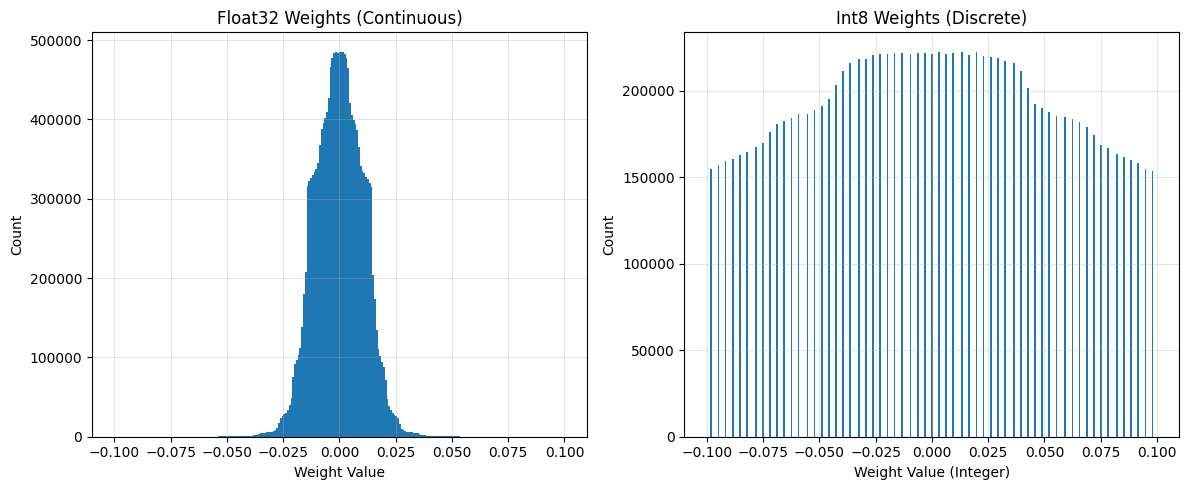


DISCRETE NATURE OF QUANTIZED WEIGHTS

Top 10 most common weight values:
     1: 222,692 occurrences
     4: 222,394 occurrences
     6: 222,391 occurrences
    -5: 222,118 occurrences
    -1: 221,990 occurrences
     3: 221,919 occurrences
    -4: 221,713 occurrences
    -2: 221,650 occurrences
     2: 221,584 occurrences
     0: 221,454 occurrences

Weight value statistics:
  Most common: 1 (222,692 occurrences)
  Least common: -125 (1 occurrences)
  Zero weights: 221,454


In [50]:
print("\n" + "="*60)
print("CHECKING WEIGHT HISTOGRAM DIFFERENCE")
print("="*60)

# Collect weights from both models
def get_all_weights(model):
    weights = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            w = module.weight.data.cpu().numpy().ravel()
            weights.append(w)
    return np.concatenate(weights) if weights else np.array([])

float_weights = get_all_weights(unet)
quant_weights = get_all_weights(unet_quantized)

print(f"Float32 weights: {len(float_weights):,} parameters")
print(f"Int8 weights: {len(quant_weights):,} parameters")

# Check integer nature
is_integer = np.allclose(quant_weights, np.round(quant_weights), atol=1e-3)
print(f"\nQuantized weights are integers: {is_integer}")
if is_integer:
    unique_vals = len(np.unique(quant_weights))
    min_val = int(np.min(quant_weights))
    max_val = int(np.max(quant_weights))
    print(f"Unique integer values: {unique_vals}")
    print(f"Integer range: [{min_val}, {max_val}]")

# ----------------------------
# Create histogram (fig, ax)
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

nbins = 127 * 2
bins = np.linspace(-0.1, 0.1, nbins)

# Float weights
ax[0].hist(float_weights, bins=bins)
ax[0].set_title('Float32 Weights (Continuous)')
ax[0].set_xlabel('Weight Value')
ax[0].set_ylabel('Count')
ax[0].grid(True, alpha=0.3)

# Quantized weights
abs_max = np.max(np.abs(quant_weights))
print(f"Absolute max: {abs_max}")

# Put quant weights back into original scale (as in your code)
quant_weights_original_scale = quant_weights * unet_quantized.input_scale

ax[1].hist(
    quant_weights * (np.max(float_weights) / np.max(quant_weights)),
    bins=bins
)
ax[1].set_title('Int8 Weights (Discrete)')
ax[1].set_xlabel('Weight Value (Integer)')
ax[1].set_ylabel('Count')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Show discrete nature clearly
# ----------------------------
print("\n" + "="*60)
print("DISCRETE NATURE OF QUANTIZED WEIGHTS")
print("="*60)

# Get unique values and counts
unique_values, counts = np.unique(quant_weights, return_counts=True)

print(f"\nTop 10 most common weight values:")
sorted_idx = np.argsort(counts)[::-1]
for i in range(min(10, len(unique_values))):
    idx = sorted_idx[i]
    print(f"  {int(unique_values[idx]):4d}: {counts[idx]:,} occurrences")

print(f"\nWeight value statistics:")
print(f"  Most common: {int(unique_values[sorted_idx[0]])} ({counts[sorted_idx[0]]:,} occurrences)")
print(f"  Least common: {int(unique_values[sorted_idx[-1]])} ({counts[sorted_idx[-1]]:,} occurrences)")
print(f"  Zero weights: {counts[unique_values == 0][0] if 0 in unique_values else 0:,}")


In [25]:
unet_quantized.input_scale


np.float32(6.1283774)

In [30]:
for n in quant_weights[:10]:
  print(n)

-44.0
-18.0
-2.0
-89.0
32.0
-75.0
-89.0
93.0
35.0
47.0


In [31]:
def check_quantization_status(model, model_name="model"):
    """Check if weights are actually quantized"""
    print(f"\n{'='*60}")
    print(f"CHECKING {model_name.upper()} QUANTIZATION STATUS")
    print(f"{'='*60}")

    int_count = 0
    float_count = 0
    has_scale_count = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            weights = module.weight.data.cpu().numpy().flatten()

            # Check if weights are integers
            is_integer = np.allclose(weights, np.round(weights), atol=1e-3)

            # Check if has scale attribute
            has_scale = hasattr(module.weight, 'scale')

            if is_integer:
                int_count += 1
                int_range = f"[{int(np.min(weights))}, {int(np.max(weights))}]"
                unique_vals = len(np.unique(weights))
                print(f"✓ {name}: INTEGER weights, {unique_vals} unique values, range {int_range}")
            else:
                float_count += 1
                print(f"✗ {name}: FLOAT weights")

            if has_scale:
                has_scale_count += 1
                print(f"  Scale: {module.weight.scale}")

    print(f"\nSummary for {model_name}:")
    print(f"  Integer weight layers: {int_count}")
    print(f"  Float weight layers: {float_count}")
    print(f"  Layers with scale attribute: {has_scale_count}")

    return int_count > 0  # Return True if any integer weights found

# Check both models
print("Checking original UNet...")
orig_has_int = check_quantization_status(unet, "Original UNet")

print("\nChecking quantized UNet...")
quant_has_int = check_quantization_status(unet_quantized, "Quantized UNet")

if not quant_has_int:
    print("\n❌ PROBLEM DETECTED: Quantized model doesn't have integer weights!")
    print("The quantization process didn't actually convert weights to integers.")

Checking original UNet...

CHECKING ORIGINAL UNET QUANTIZATION STATUS
✗ inc.double_conv.0: FLOAT weights
✗ inc.double_conv.3: FLOAT weights
✗ downs.0.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.0.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.1.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.1.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.2.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.2.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.3.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.3.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.4.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.4.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.5.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.5.maxpool_conv.1.double_conv.3: FLOAT weights
✗ downs.6.maxpool_conv.1.double_conv.0: FLOAT weights
✗ downs.6.maxpool_conv.1.double_conv.3: FLOAT weights
✗ ups.0.conv.double_conv.0: FLOAT weights
✗ ups.0.conv.double_conv.3: FLOAT weights
✗ ups.1.conv.double_

SIMPLE WEIGHT HISTOGRAM COMPARISON
Number of parameters:
  Float32: 17,300,824
  Int8:    17,300,824

Float32 Statistics:
  Mean:  -0.000063
  Std:   0.010823
  Min:   -0.372615
  Max:   0.416176
  Abs Max: 0.416176

Int8 Statistics:
  Mean:  -0.169058
  Std:   27.988974
  Min:   -127.000000
  Max:   127.000000
  Abs Max: 127.000000

Quantized weights are integers: True
Unique integer values: 252
Integer range: [-127, 127]


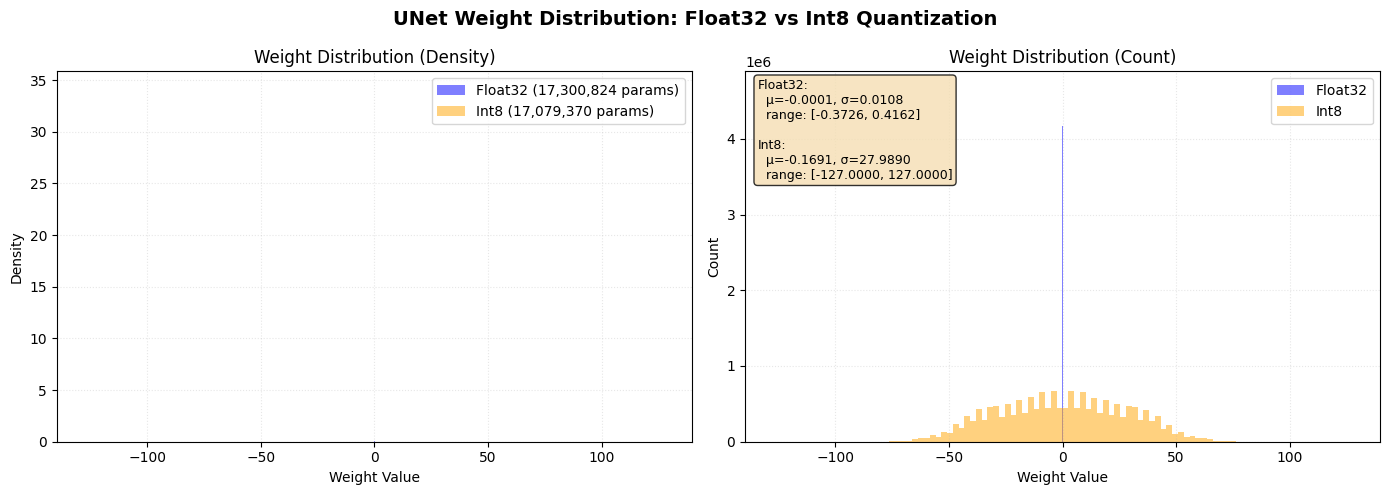

In [32]:
def plot_weight_histogram_comparison(float_model, quant_model, bins=100, log_scale=False):
    """
    Simple histogram comparison of float vs quantized weights
    """
    def collect_weights(model):
        """Collect all weights from a model"""
        weights = []
        for module in model.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                # Get the weight tensor
                w = module.weight.detach().cpu().numpy().ravel()
                weights.append(w)
        return np.concatenate(weights) if weights else np.array([])

    # Collect weights from both models
    float_weights = collect_weights(float_model)
    quant_weights = collect_weights(quant_model)

    print(f"Number of parameters:")
    print(f"  Float32: {len(float_weights):,}")
    print(f"  Int8:    {len(quant_weights):,}")

    # Filter out very small values (optional)
    eps = 1e-15
    float_weights_filtered = float_weights[abs(float_weights) > eps]
    quant_weights_filtered = quant_weights[abs(quant_weights) > eps]

    # Calculate statistics
    float_stats = {
        'mean': np.mean(float_weights_filtered),
        'std': np.std(float_weights_filtered),
        'min': np.min(float_weights_filtered),
        'max': np.max(float_weights_filtered),
        'abs_max': np.max(np.abs(float_weights_filtered))
    }

    quant_stats = {
        'mean': np.mean(quant_weights_filtered),
        'std': np.std(quant_weights_filtered),
        'min': np.min(quant_weights_filtered),
        'max': np.max(quant_weights_filtered),
        'abs_max': np.max(np.abs(quant_weights_filtered))
    }

    # Print statistics
    print("\nFloat32 Statistics:")
    print(f"  Mean:  {float_stats['mean']:.6f}")
    print(f"  Std:   {float_stats['std']:.6f}")
    print(f"  Min:   {float_stats['min']:.6f}")
    print(f"  Max:   {float_stats['max']:.6f}")
    print(f"  Abs Max: {float_stats['abs_max']:.6f}")

    print("\nInt8 Statistics:")
    print(f"  Mean:  {quant_stats['mean']:.6f}")
    print(f"  Std:   {quant_stats['std']:.6f}")
    print(f"  Min:   {quant_stats['min']:.6f}")
    print(f"  Max:   {quant_stats['max']:.6f}")
    print(f"  Abs Max: {quant_stats['abs_max']:.6f}")

    # Check if quantized weights are integers
    is_integer = np.allclose(quant_weights_filtered, np.round(quant_weights_filtered), atol=1e-3)
    print(f"\nQuantized weights are integers: {is_integer}")
    if is_integer:
        unique_vals = len(np.unique(quant_weights_filtered))
        print(f"Unique integer values: {unique_vals}")
        print(f"Integer range: [{int(np.min(quant_weights_filtered))}, {int(np.max(quant_weights_filtered))}]")

    # Create histogram
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Linear scale
    axes[0].hist(float_weights_filtered, bins=bins, alpha=0.5,
                 label=f'Float32 ({len(float_weights_filtered):,} params)',
                 density=True, color='blue')
    axes[0].hist(quant_weights_filtered, bins=bins, alpha=0.5,
                 label=f'Int8 ({len(quant_weights_filtered):,} params)',
                 density=True, color='orange')
    axes[0].set_xlabel('Weight Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Weight Distribution (Density)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, linestyle=':')

    # Plot 2: Log scale (if requested) or count histogram
    if log_scale:
        # Use log scale for y-axis
        axes[1].hist(float_weights_filtered, bins=bins, alpha=0.5,
                     label='Float32', color='blue', log=True)
        axes[1].hist(quant_weights_filtered, bins=bins, alpha=0.5,
                     label='Int8', color='orange', log=True)
        axes[1].set_ylabel('Count (log scale)')
        axes[1].set_title('Weight Distribution (Log Count)')
    else:
        # Regular count histogram
        axes[1].hist(float_weights_filtered, bins=bins, alpha=0.5,
                     label='Float32', color='blue')
        axes[1].hist(quant_weights_filtered, bins=bins, alpha=0.5,
                     label='Int8', color='orange')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Weight Distribution (Count)')

    axes[1].set_xlabel('Weight Value')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, linestyle=':')

    # Add statistics text to second plot
    stats_text = (f"Float32:\n"
                  f"  μ={float_stats['mean']:.4f}, σ={float_stats['std']:.4f}\n"
                  f"  range: [{float_stats['min']:.4f}, {float_stats['max']:.4f}]\n\n"
                  f"Int8:\n"
                  f"  μ={quant_stats['mean']:.4f}, σ={quant_stats['std']:.4f}\n"
                  f"  range: [{quant_stats['min']:.4f}, {quant_stats['max']:.4f}]")

    axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.suptitle('UNet Weight Distribution: Float32 vs Int8 Quantization',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return float_stats, quant_stats

# Run the simple histogram comparison
print("="*60)
print("SIMPLE WEIGHT HISTOGRAM COMPARISON")
print("="*60)

float_stats, quant_stats = plot_weight_histogram_comparison(
    unet, unet_quantized, bins=100, log_scale=False
)

### Quantization Aware Training

In [33]:
def plot_weight_histogram(model, bins, log_switch):
  eps = 1e-15
  vals = []
  for module in model.modules():
    if hasattr(module, "weight"):
        if hasattr(module, "weight_mask"):
            w = module.weight_orig.detach().cpu().numpy()
            m = module.weight_mask.detach().cpu().numpy()
            vals.append(w[m == 1])
        else:
            vals.append(module.weight.detach().cpu().numpy().ravel())

  all_vals = np.concatenate(vals)
  all_vals = all_vals[abs(all_vals) > eps]
  print(f'Number of paramaters: ', len(all_vals))

  mean = np.mean(all_vals)
  std = np.std(all_vals)
  max = np.max(all_vals)
  min = np.min(all_vals)
  print(f"Mean: {mean}, std: {std}, max: {max}, min: {min}")
  log_vals = np.log10(abs(all_vals + eps))

  fig, ax = plt.subplots(figsize=(7, 5))
  ax.hist(all_vals, bins=bins, edgecolor='black', log=log_switch)
  ax.set_xlim([-0.06,0.06])
  ax.set_ylim([0,1.2e6])
  ax.set_xlabel("Weight value")
  ax.set_ylabel("Count")
  # ax.set_title("Model Weight Histogram")
  ax.grid(True, linestyle=":", alpha=0.5)

  # wandb.log(
  #     {"weights/histogram": wandb.Image(fig)},
  #     step=None
  # )
  plt.show()


Number of paramaters:  17305408
Mean: 0.00020206144836265594, std: 0.019544681534171104, max: 1.428755760192871, min: -0.3726149797439575


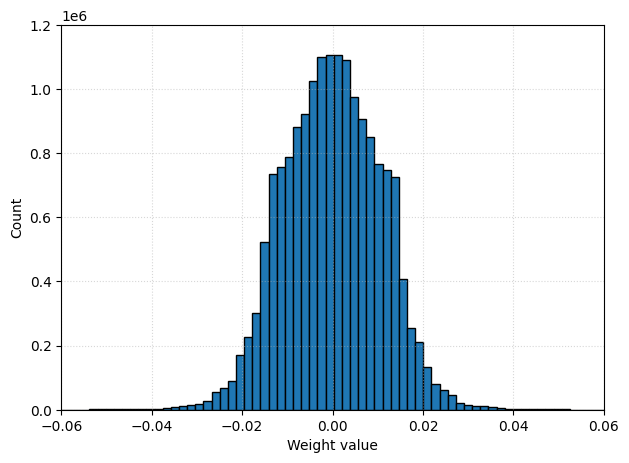

In [34]:
plot_weight_histogram(unet, bins=1000, log_switch=False)

val loss train loss

# Test Set Evaluation

In [35]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)

print(f"Error on the testing set: {errors.mean()}")

Error on the testing set: 0.0021344260312616825


In [36]:
# Convert to numpy arrays
inputs_cpu = inputs.cpu().numpy()
predictions_cpu = predictions.cpu().numpy()
truths_cpu = truths.cpu().numpy()
masks_cpu = masks.cpu().numpy()
errors_cpu = errors.cpu().numpy()

/tmp/ipython-input-825397190.py:14: RuntimeWarning: invalid value encountered in divide
  residual_x = (truth_x - predicted_x) / truth_x
/tmp/ipython-input-825397190.py:15: RuntimeWarning: invalid value encountered in divide
  residual_y = (truth_y - predicted_y) / truth_y


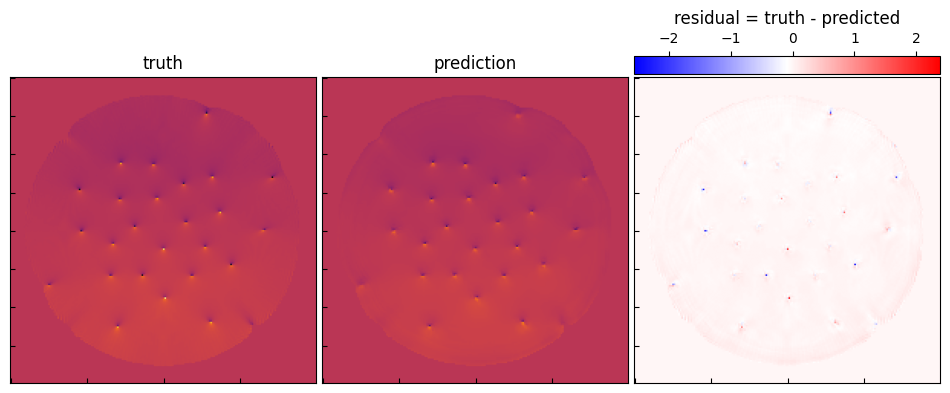

In [42]:
# Visualize a prediction
idx = 100
vmin = truths_cpu.min()
vmax = truths_cpu.max()
fig, ax = plt.subplots(1, 3, figsize=(12, 8), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.02, wspace=0.02)
truth_x = truths_cpu[idx, 0]
truth_y = truths_cpu[idx, 1]

predicted_x = predictions_cpu[idx, 0] * (1 - masks_cpu[idx, 0])
predicted_y = predictions_cpu[idx, 1] * (1 - masks_cpu[idx, 1])

residual_x = (truth_x - predicted_x) / truth_x
residual_y = (truth_y - predicted_y) / truth_y

# Only where truth != 0
percentage_error_x = np.zeros_like(truth_x)
mask = truth_x != 0
percentage_error_x[mask] = 100 * (truth_x[mask] - predicted_x[mask]) / truth_x[mask]

residual = truth_x- predicted_x
ax[0].imshow(truth_x, vmin=vmin, vmax=vmax, cmap="inferno")
ax[1].imshow(predicted_x, vmin=vmin, vmax=vmax, cmap="inferno")
# ax[3].imshow(truth_y , vmin = vmin, vmax = vmax)
# ax[4].imshow(predicted_y, vmin = vmin, vmax = vmax)

# show the residual in the 3 column
resim = ax[2].imshow(residual,  cmap="bwr")
# ax[5].imshow(residual_y, vmin = -1, vmax = 1, cmap="bwr")
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

# make an inset axis for ax[2]
cbar_inset = ax[2].inset_axes([0, 1.01, 1, 0.06])

# make a colorbar using cbar_inset

cbar = fig.colorbar(resim, cax=cbar_inset, orientation="horizontal")
cbar_inset.set_title(r"residual = truth - predicted")
# put ticks on top of the cbar
cbar_inset.xaxis.set_ticks_position("top")
# fig.colorbar(resim, ax=ax[2], location='top', label='Residual Value', fraction=0.046, pad=0.04)


ax[0].set_title("truth")
ax[1].set_title("prediction")


plt.savefig(
    os.path.join(data_loc, "final_example_residual.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

In [ ]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths_cpu, axis=(-1, -2, -3))
all_errors = np.concatenate([errors_cpu, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(
    errors_cpu, alpha=0.5, bins=bin_edges, label="ML", color="skyblue", edgecolor="black"
)
plt.hist(
    baseline_errors,
    alpha=0.5,
    bins=bin_edges,
    label="Baseline",
    color="orange",
    edgecolor="black",
)
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")